# March Madness Rating Computation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from data_format.rating_systems.stephenson import *
from data_format.rating_systems.glicko2 import *
from data_format.rating_systems.elo_v2 import *
import copy
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, brier_score_loss, mean_absolute_error
from sklearn.preprocessing import StandardScaler


In [2]:
DATA_PATH = 'data/'

tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneyDetailedResults.csv"),
    # pd.read_csv(DATA_PATH + "womens/WNCAATourneyDetailedResults.csv"),
], ignore_index=True)

seeds = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MNCAATourneySeeds.csv"),
    # pd.read_csv(DATA_PATH + "womens/WNCAATourneySeeds.csv"),
], ignore_index=True)

regular_results = pd.concat([
    pd.read_csv(DATA_PATH + "mens/MRegularSeasonDetailedResults.csv"),
    # pd.read_csv(DATA_PATH + "womens/WRegularSeasonDetailedResults.csv"),
], ignore_index=True)



In [3]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']

    output['win'] = np.where(output['T1_Score']>output['T2_Score'], 1, 0)

    output['T1_TeamID'] = output['T1_TeamID'].astype(str)
    output['T2_TeamID'] = output['T2_TeamID'].astype(str)
    
    return output

In [4]:
tourney_data = prepare_data(tourney_results)
regular_data = prepare_data(regular_results)

In [5]:
# not interested in pre-selection matches - first four started 2011 mens 2022 women
# 136 FOR MENS 137 FOR WOMEN
tourney_data = tourney_data.loc[tourney_data['DayNum'] >= 136].reset_index(drop=True)
# tourney_data = tourney_data.loc[tourney_data['DayNum'] >= 137].reset_index(drop=True)

# #Add round
def assign_intervals(day_nums):
    day_to_interval = {}
    days = sorted(set(day_nums)) #unique + sorted

    interval_mapping = {
        (0, 1): 1, # First round
        (2, 3): 2, # Second round
        (4, 5): 3, # Sweet sixteen
        (6, 7): 4, # Elite eight
        (8, 8): 5, # Final four
        (9, 9): 6, # Finals
    }

    for i, day in enumerate(days):
        for (start, end), interval in interval_mapping.items():
            if start <= i <= end:
                day_to_interval[day] = interval
                break

    return day_nums.map(day_to_interval)  # Map backto index

# Apply function to each Season group
tourney_data['round'] = tourney_data.groupby("Season")['DayNum'].transform(assign_intervals)
# tourney_data = tourney_data.drop(columns=['DayNum'])

In [6]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

In [7]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean")
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg("mean").reset_index()
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]

In [8]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [9]:
tourney_data = tourney_data[['Season', 'round', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [10]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [11]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [12]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.shape

(12300, 5)

In [13]:
def team_quality_s(season):
    year_regular_results = regular_results[(regular_results['Season'] == season)]
    # year_tourney_results = tourney_results[(tourney_results['Season'] == season)]

    combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
    all_teams = combined_teams.drop_duplicates().tolist()

    team_data = {
        'TeamID': all_teams,   
        'steph_rating': [Stephenson() for _ in all_teams],
    }

    df_team = pd.DataFrame(team_data)

    for index, row in year_regular_results.iterrows():
        team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'].values[0]
        team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'].values[0]

        #Replacing updateVal since this is not by date but by week 10^2 = 100 (cval)
        team_one.sigma = team_one.sigma + 100
        team_two.sigma = team_two.sigma + 100

        # So we don't evaluate on outcome
        home_clone = copy.deepcopy(team_one)

        point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])
        # point_ratio = row['win']

        match row['location']:
            case 'H':
                team_one.newVarRating(team_two, point_ratio, 1) #pone is 1 for home team, -1 away, 0 unknown
                team_two.newVarRating(home_clone, (1 - point_ratio), -1) 
            case 'A':
                team_one.newVarRating(team_two, point_ratio, -1)
                team_two.newVarRating(home_clone, (1 - point_ratio), 1) 
            case _:
                team_one.newVarRating(team_two, point_ratio, 0)
                team_two.newVarRating(home_clone, (1 - point_ratio), 0) 

        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'steph_rating'] = team_one
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'steph_rating'] = team_two

    df_team = df_team.assign(quality=df_team['steph_rating'].apply(lambda x: x.getRating()))
    df_team = df_team.sort_values(by="quality", ascending=False)

    # Select only the required columns
    new_team_df = df_team[['TeamID', 'quality']].reset_index(drop=True)
    new_team_df['Season'] = season
    new_team_df['TeamID'] = new_team_df['TeamID'].astype(int)
    return new_team_df

In [14]:
def team_quality(season):
    year_regular_results = regular_data[(regular_data['Season'] == season)]
    # year_tourney_results = tourney_results[(tourney_results['Season'] == season)]

    combined_teams = pd.concat([year_regular_results['T1_TeamID'], year_regular_results['T2_TeamID']]) 
    all_teams = combined_teams.drop_duplicates().tolist()

    team_data = {
        'TeamID': all_teams,
        'rating': [Rating() for _ in all_teams],
        'point_rating': [Rating() for _ in all_teams],
    }

    df_team = pd.DataFrame(team_data)

    for index, row in year_regular_results.iterrows():
        #Win loss rating
        team_one = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'rating'].values[0]
        team_two = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'rating'].values[0]

        # So we don't evaluate on outcome
        home_point = copy.deepcopy(team_one)

        team_one.update_player(team_two.getRating(), team_two.getRd(), row['win'])
        team_two.update_player(home_point.getRating(), home_point.getRd(), (1 - row['win']))

        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'rating'] = team_one
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'rating'] = team_two


        #Total point differential rating
        team_one_point = df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'point_rating'].values[0]
        team_two_point = df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'point_rating'].values[0]

        # So we don't evaluate on outcome
        home_point_clone = copy.deepcopy(team_one_point)
        point_ratio = float(row['T1_Score']) / (row['T1_Score'] + row['T2_Score'])

        team_one_point.update_player(team_two_point.getRating(), team_two_point.getRd(), point_ratio)
        team_two_point.update_player(home_point_clone.getRating(), home_point_clone.getRd(), (1 - point_ratio))

        df_team.loc[df_team['TeamID'] == row['T1_TeamID'], 'point_rating'] = team_one_point
        df_team.loc[df_team['TeamID'] == row['T2_TeamID'], 'point_rating'] = team_two_point


    df_team = df_team.assign(quality=df_team['rating'].apply(lambda x: x.getRating()))
    df_team = df_team.assign(quality_vol=df_team['rating'].apply(lambda x: x.getVol()))
    df_team = df_team.assign(quality_points=df_team['point_rating'].apply(lambda x: x.getRating()))
    df_team = df_team.assign(quality_points_vol=df_team['point_rating'].apply(lambda x: x.getVol()))
    df_team = df_team.sort_values(by="quality", ascending=False)

    # Select only the required columns
    new_team_df = df_team[['TeamID', 'quality', 'quality_vol', 'quality_points', 'quality_points_vol']].reset_index(drop=True)
    # new_team_df = df_team[['TeamID', 'quality']].reset_index(drop=True)
    new_team_df['Season'] = season
    new_team_df['TeamID'] = new_team_df['TeamID'].astype(int)
    return new_team_df

In [15]:
glm_quality = pd.concat([team_quality(2010),
                         team_quality(2011),
                         team_quality(2012),
                         team_quality(2013),
                         team_quality(2014),
                         team_quality(2015),
                         team_quality(2016),
                         team_quality(2017),
                         team_quality(2018),
                         team_quality(2019),
                         ##team_quality(2020),
                         team_quality(2021),
                         team_quality(2022),
                         team_quality(2023),
                         team_quality(2024)
                         ]).reset_index(drop=True)

In [16]:
glm_quality_T1 = glm_quality.copy()
glm_quality_T2 = glm_quality.copy()
glm_quality_T1.columns = ['T1_TeamID','T1_quality','T1_quality_vol','T1_quality_points','T1_quality_points_vol','Season']
glm_quality_T2.columns = ['T2_TeamID','T2_quality','T2_quality_vol','T2_quality_points','T2_quality_points_vol','Season']

# glm_quality_T1.columns = ['T1_TeamID','T1_quality','Season']
# glm_quality_T2.columns = ['T2_TeamID','T2_quality','Season']

glm_quality_T1['T1_TeamID'] = glm_quality_T1['T1_TeamID'].astype(str)
glm_quality_T2['T2_TeamID'] = glm_quality_T2['T2_TeamID'].astype(str)

tourney_data['T1_TeamID'] = tourney_data['T1_TeamID'].astype(str)
tourney_data['T2_TeamID'] = tourney_data['T2_TeamID'].astype(str)


In [17]:
tourney_data = pd.merge(tourney_data, glm_quality_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, glm_quality_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [18]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))

In [19]:
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

seeds_T1['T1_TeamID'] = seeds_T1['T1_TeamID'].astype(str)
seeds_T2['T2_TeamID'] = seeds_T2['T2_TeamID'].astype(str)

In [20]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [21]:
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data["qual_diff"] = tourney_data["T1_quality"] - tourney_data["T2_quality"]
tourney_data["qual_point_diff"] = tourney_data["T1_quality_points"] - tourney_data["T2_quality_points"]
tourney_data["avg_qual_point"] = (tourney_data["T1_quality_points"] + tourney_data["T2_quality_points"])/2
tourney_data["avg_qual"] = (tourney_data["T1_quality"] + tourney_data["T2_quality"])/2

tourney_data = tourney_data.dropna()

# March Madness teams - team strength overview

In [22]:
def trainModel(features, df_train, df_validate):
    y_train = df_train["Result"]
    y_validate = df_validate["Result"]

    X_train = df_train[features]
    X_validate = df_validate[features]

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_validate, label=y_validate, reference=lgb_train)

    # params = {
    #     'objective': 'regression',
    #     'metric': 'mae',
    #     'boosting_type': 'gbdt',
    #     'num_leaves': 7, #31
    #     'learning_rate': 0.05, #change to ~0.02 for final run
    #     'feature_fraction': 0.7, #0.9, # 1 by default - helps overfitting
    #     # 'bagging_freq' : 10,
    #     'verbosity': -1,
    #     # 'boost_from_average': True,
    #     # 'feature_pre_filter': False,
    #     'subsample': 0.35,
    #     'min_child_samples': 40,
    #     'lambda_l1': 10,
    # }

    # gbm = lgb.train(
    #     params,
    #     lgb_train,
    #     num_boost_round=3000, #50 # More iterations for better convergence
    #     valid_sets=lgb_eval,
    #     callbacks=[lgb.early_stopping(stopping_rounds=25)],
    # )

    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_freq' : 10,
        'verbosity': -1,
        'boost_from_average': True,
        'feature_pre_filter': False,
    }

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=50,  # More iterations for better convergence
        valid_sets=lgb_eval,
        callbacks=[lgb.early_stopping(stopping_rounds=50)],
    )

    # Return the trained model
    return gbm

In [23]:
def evaluateModel(model, df_test, features):
    X_test = df_test[features]
    y_test = df_test["Result"]

    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    # Convert numerical predictions to binary (1 if positive, 0 if negative)
    y_test_binary = (y_test > 0).astype(int)
    y_pred_binary = (y_pred > 0).astype(int)

    # Compute regression metrics
    mae = mean_absolute_error(y_test, y_pred)
    brier = brier_score_loss(y_test_binary, np.clip(y_pred, 0, 1))  # Clipping for Brier score

    # Compute classification metrics
    accuracy = accuracy_score(y_test_binary, y_pred_binary)
    auc = roc_auc_score(y_test_binary, y_pred)

    return {
        'mae': mae,
        'brier_score': brier,
        'accuracy': accuracy,
        'auc': auc
    }

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[41]	valid_0's l1: 9.32882
Accuracy: 0.7170
AUC: 0.7787
Mae: 9.3288
brier: 0.2799


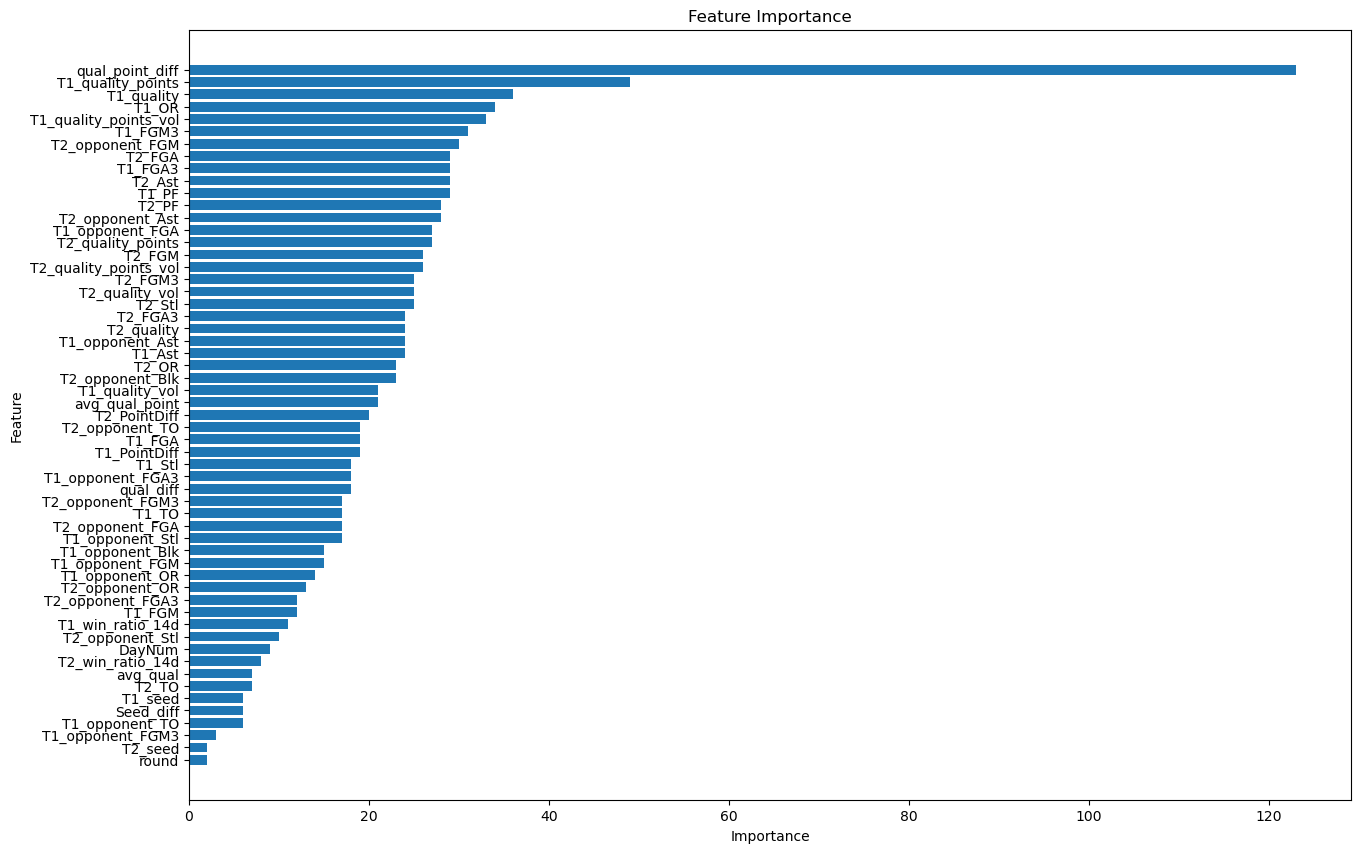

In [24]:
# Data cleaning and filtering
df = tourney_data.dropna()

y = df['T1_Score'] - df['T2_Score']

df = df.drop(columns=['Season', 'T1_TeamID', 'T1_Score','T2_TeamID', 'T2_Score',])

X = df.to_numpy()  # Ensures full conversion without dropping metadata

# Normalize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_validate, X_test, y_validate, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# Convert to DataFrames for model compatibility
df_train = pd.DataFrame(X_train, columns=df.columns)
df_train['Result'] = y_train.reset_index(drop=True)

df_validate = pd.DataFrame(X_validate, columns=df.columns)
df_validate['Result'] = y_validate.reset_index(drop=True)

df_test = pd.DataFrame(X_test, columns=df.columns)
df_test['Result'] = y_test.reset_index(drop=True)


# Train model
selected_features = df_train.columns.drop('Result').tolist()
model = trainModel(selected_features, df_train, df_validate)

# Evaluate model
evaluation_metrics = evaluateModel(model, df_validate, selected_features)

print(f"Accuracy: {evaluation_metrics['accuracy']:.4f}")
print(f"AUC: {evaluation_metrics['auc']:.4f}")
print(f"Mae: {evaluation_metrics['mae']:.4f}")
print(f"brier: {evaluation_metrics['brier_score']:.4f}")

# Feature importance
importances = model.feature_importance()
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(15, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Save model
model.save_model('lightgbm_model.txt')

# Predictions
y_pred = model.predict(X_test)

# brier = brier_score_loss(y_test, y_pred)  # Use probabilities
# print(f"Brier: {brier}")


# Convert all inputs to DataFrames/Series and reset index to ensure alignment
X_test = pd.DataFrame(X_test).reset_index(drop=True) if isinstance(X_test, np.ndarray) else X_test.reset_index(drop=True)
X_test.columns = selected_features


y_pred = pd.Series(y_pred, name="y_pred").reset_index(drop=True) if isinstance(y_pred, np.ndarray) else y_pred.reset_index(drop=True)
y_test = pd.Series(y_test, name="y_test").reset_index(drop=True) if isinstance(y_test, np.ndarray) else y_test.reset_index(drop=True)


# Concatenate along columns, ensuring the indexes match
final_compare = pd.concat([X_test, y_pred, y_test], axis=1)
